#### Partners for this Homework are:
Pinaki Bhagat   
Sydney Correa

Kaggle Team Name: 20178ml08

Ideas tried in multiple subsmissions are outlined below:

1. Combine x,y,z into a single point
2. Look at subject vs phase vs output mapping and add additional features in the dataset
3. Drop the following:    
    a. Original "subject","phase","state","indicator"   
    b. Drop all 0 value featues   
    c. Drop all highly correlated features (>.9)   
4. Perform PCA
5. Handle distribution of class weight in several ways:   
    a. Use class weight parameter for providing weighted values for uneven output classes   
    b. Use upsampling technique (SMOTE)   
6. Use individual algorithms such as Random Forest and XGBoost to find out accuracy and AUC  
    a. Hyper tuning of parameters  
7. Use primary components from PCA to develop model
8. Try Stacking with 4 initial algorithms and use final as XGBoost

Though a host of ways have been explored and multiple submissions made, AUC never went up beyond 62%. Considering heavy work loads (year end approaching) we didn't get as much time as we would like to spend on this. Given the luxury of time, we would have tried several other methods like these below to better our predictions:  
a. Upsampling of clusters   
b. Few other ensemble methods    

##### Import all python libraries

In [144]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from datetime import datetime
import requests
from io import BytesIO
import seaborn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import sklearn
from sklearn import neighbors, decomposition, metrics, preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn import decomposition, preprocessing
from scipy.spatial import distance

import math
import warnings

warnings.simplefilter("ignore")

##### Define function to combine x,y,z inputs and code categorical variables

In [2]:
def sensor_combine(sensor_in):

    #from scipy.spatial import distance
    sensor_x = np.array
    sensor_y = np.array
    sensor_z = np.array

    sensor_x = sensor_in.iloc[:,0:221].values
    sensor_y = sensor_in.iloc[:,222:443].values
    sensor_z = sensor_in.iloc[:,444:665].values
    
    sensor_xyz = np.sqrt(np.square(sensor_x) + np.square(sensor_y) + np.square(sensor_y))
    
    df_sensor_xyz = pd.DataFrame(data=(sensor_xyz))
    
    #adding categorical encoding
    sensor_catg = sensor_in[['SubA_Phase1','SubI_Phase1','SubM_Phase1','SubA_Phase2','SubF_Phase2','SubI_Phase3','SubL_Phase3','SubL_Phase4','SubI_Phase4']]
    
    frames = [df_sensor_xyz, sensor_catg]
    df_sensor_combine = pd.concat(frames, axis=1)
      
    return df_sensor_combine

##### Download train dataset

In [163]:
url = 'C:\\Users\\corre\\Desktop\\CSCI E-82\\PS 4\\all\\train_data.csv'
#url = 'C:\\Users\\pinakibhagat\\Downloads\\Personal\\Harvard\\CSCIE-82\\Homework 4\\all\\train_data.csv'
sensor_train = pd.read_csv(url, sep=',')

print(sensor_train.shape)

(4584, 670)


##### Download test dataset

In [164]:
url1 = 'C:\\Users\\corre\\Desktop\\CSCI E-82\\PS 4\\all\\test_data.csv'
#url1 = 'C:\\Users\\pinakibhagat\\Downloads\\Personal\\Harvard\\CSCIE-82\\Homework 4\\all\\test_data.csv'
sensor_test = pd.read_csv(url1, sep=',')

sensor_test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,4.665949,0.083412,-17.397081,0.067865,0.005895,0.000012,...,-0.017574,-0.004402,0.016508,-540.645279,-1511.001159,-1408.385976,-437.807290,E,4,D
1,0,0,0,0,-398.299487,0.784032,-10.785768,403.784446,0.070405,0.000180,...,0.029533,0.113692,0.088024,-3.140961,-0.658456,-0.140010,-0.011017,H,4,D
2,0,0,0,1,-380.902140,0.671324,-9.265829,361.841929,0.006937,0.000025,...,-0.006361,0.005852,-0.003745,-14.340790,4.182214,-0.549953,0.019553,C,4,B
3,0,0,0,1,-342.784123,0.469414,-8.044287,293.043601,0.007217,-0.000021,...,0.001950,-0.003426,-0.011191,251.659680,-441.129598,256.986592,-49.745359,H,1,C
4,0,0,0,1,6.248502,0.252336,-5.398056,0.110097,0.005573,0.000010,...,-0.001916,-0.015666,-0.015960,-137.847658,-377.758402,-345.673251,-105.633150,E,4,B


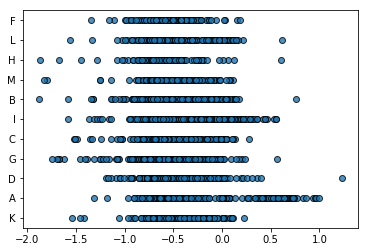

In [156]:

plt.scatter(sensor_train.x150, sensor_train.subject, alpha=0.8, edgecolor='k')

##### Add indicator to combine and split later

In [165]:
sensor_train['indicator']='train'
sensor_test['indicator']='test'

Y = sensor_train.output
sensor_train.drop('output',inplace=True, axis=1)

##### Combine test and train datasets

In [166]:
df_sensor_all = pd.concat([sensor_train,sensor_test])
df_sensor_all.reset_index(inplace=True, drop=True) #drop index
df_sensor_all.shape

(6316, 670)

##### Create additional features based on outcome of feature engineering

In [167]:
df_sensor_all['SubjectK'] = 0 
df_sensor_all.loc[df_sensor_all[df_sensor_all.subject=='K'].index,'SubjectK']=1 

In [168]:
#Step by step
i1 = df_sensor_all[((df_sensor_all.phase==1) & (df_sensor_all.subject=='A'))].index
arr = np.zeros(df_sensor_all.shape[0],dtype=int)
arr[i1]=1
df_sensor_all['SubA_Phase1']=arr

#concise
df_sensor_all['SubI_Phase1'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==1) & (df_sensor_all.subject=='I'))].index,'SubI_Phase1'] = 1

df_sensor_all['SubM_Phase1'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==1) & (df_sensor_all.subject=='M'))].index,'SubM_Phase1'] = 1

df_sensor_all['SubA_Phase2'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==2) & (df_sensor_all.subject=='A'))].index,'SubA_Phase2'] = 1

df_sensor_all['SubF_Phase2'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==2) & (df_sensor_all.subject=='F'))].index,'SubF_Phase2'] = 1

df_sensor_all['SubI_Phase3'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==3) & (df_sensor_all.subject=='I'))].index,'SubI_Phase3'] = 1

df_sensor_all['SubL_Phase3'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==3) & (df_sensor_all.subject=='L'))].index,'SubL_Phase3'] = 1

df_sensor_all['SubL_Phase4'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==4) & (df_sensor_all.subject=='L'))].index,'SubL_Phase4'] = 1

df_sensor_all['SubI_Phase4'] = 0
df_sensor_all.loc[df_sensor_all[((df_sensor_all.phase==4) & (df_sensor_all.subject=='I'))].index,'SubI_Phase4'] = 1

##### Split back into train and test datasets

In [169]:
sensor_train_1 = df_sensor_all[df_sensor_all.indicator=='train']
sensor_test_1 = df_sensor_all[df_sensor_all.indicator=='test']
sensor_train_1.reset_index(inplace=True,drop=True)
sensor_test_1.reset_index(inplace=True,drop=True)

##### Drop the categorical old features

In [170]:
sensor_train_1 = sensor_train_1.drop(['state','subject','phase','indicator'], axis=1)
sensor_test_1 = sensor_test_1.drop(['state','subject','phase','indicator'], axis=1)

##### Drop all features that are 0 and highly co-related

In [171]:
df_sensor_train = sensor_combine(sensor_train_1)
df_sensor_train.head()

,0,1,2,3,4,5,6,7,8,9,...,220,SubA_Phase1,SubI_Phase1,SubM_Phase1,SubA_Phase2,SubF_Phase2,SubI_Phase3,SubL_Phase3,SubL_Phase4,SubI_Phase4
0,0.0,0.0,0.0,1.000000,328.814989,5.436237,2.389354,261.207304,0.020474,0.000261,...,8.305806,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,1.000000,378.248867,2.546849,9.516636,355.357961,0.046146,0.000293,...,13.096989,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.000000,162.260349,4.374276,5.315971,61.553675,0.043671,0.000155,...,0.470832,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,1.732051,403.618768,4.776285,4.015523,383.280445,0.014961,0.000321,...,243.967800,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,1.414214,368.637520,6.583142,4.064181,330.977696,0.016822,0.000698,...,54.015844,0,0,0,0,0,0,0,0,0


In [172]:
df_sensor_test = sensor_combine(sensor_test_1)
print(df_sensor_test.shape)

#Combine train and test to make a single dataframe
frames = [df_sensor_train, df_sensor_test]
df_sensor_all = pd.concat(frames, axis=0)
print(df_sensor_all.shape)
#Remove all columns that are zero
df_sensor_all = df_sensor_all.loc[:, (df_sensor_all != 0).any(axis=0)]
print(df_sensor_all.shape)

#Remove all highly correlated features
corr_matrix = df_sensor_all.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

to_drop1=to_drop[1:110]

# Drop features 
df_sensor_all = df_sensor_all.drop(df_sensor_all.columns[to_drop1], axis=1)

df_sensor_train = df_sensor_all.iloc[:4584,:]
print(df_sensor_train.shape)

df_sensor_test = df_sensor_all.iloc[4584:,:]
print(df_sensor_test.shape)

X = df_sensor_train.values

(1732, 230)
(6316, 230)
(6316, 214)
(4584, 105)
(1732, 105)


,1,2,3,4,5,6,7,8,9,10,...,220,SubA_Phase1,SubI_Phase1,SubM_Phase1,SubA_Phase2,SubF_Phase2,SubI_Phase3,SubL_Phase3,SubL_Phase4,SubI_Phase4
0,0.0,0.0,1.000000,328.814989,5.436237,2.389354,261.207304,0.020474,0.000261,0.000029,...,8.305806,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.000000,378.248867,2.546849,9.516636,355.357961,0.046146,0.000293,0.000025,...,13.096989,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.000000,162.260349,4.374276,5.315971,61.553675,0.043671,0.000155,0.000093,...,0.470832,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.732051,403.618768,4.776285,4.015523,383.280445,0.014961,0.000321,0.000030,...,243.967800,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.414214,368.637520,6.583142,4.064181,330.977696,0.016822,0.000698,0.000024,...,54.015844,0,0,0,0,0,0,0,0,0



##### Perform PCA

[85.49867502 96.04306513 98.16691227 98.87239446 99.44205461 99.7388009
 99.85919166 99.91912986 99.95739594 99.9729197 ]


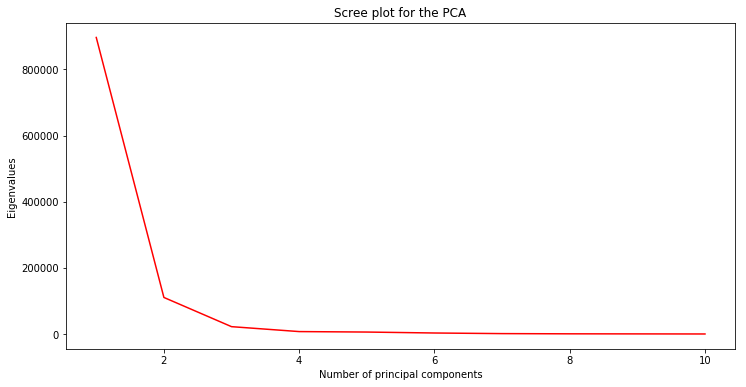

The 1st Principal Component explains 85.5 % of the variance

The 1st and 2nd Principal Components explain 96.0 % of the variance

The 1st, 2nd and 3rd Principal Components explain 98.2 % of the variance

The 1st, 2nd, 3rd and 4th Principal Components explain 98.9 % of the variance

The first five Principal Components explain 99.4 % of the variance



In [13]:
pca = sklearn.decomposition.PCA(n_components=10).fit(df_sensor_train)

coef_PCA = pca.transform(df_sensor_train)
# we make a scree plot to see how many Principal Components to consider
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_
# and calculate the variance explained by the PC analysis
var_exp = pca.explained_variance_ratio_.cumsum()*100.
print(var_exp)

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
print ('The 1st, 2nd, 3rd and 4th Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))
print ('The first five Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[4]))

##### Break the dataframe into train, validation and test set

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size=0.25, random_state=101)

In [174]:
df_sensor_train.head()

,1,2,3,4,5,6,7,8,9,10,...,220,SubA_Phase1,SubI_Phase1,SubM_Phase1,SubA_Phase2,SubF_Phase2,SubI_Phase3,SubL_Phase3,SubL_Phase4,SubI_Phase4
0,0.0,0.0,1.000000,328.814989,5.436237,2.389354,261.207304,0.020474,0.000261,0.000029,...,8.305806,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.000000,378.248867,2.546849,9.516636,355.357961,0.046146,0.000293,0.000025,...,13.096989,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.000000,162.260349,4.374276,5.315971,61.553675,0.043671,0.000155,0.000093,...,0.470832,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.732051,403.618768,4.776285,4.015523,383.280445,0.014961,0.000321,0.000030,...,243.967800,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.414214,368.637520,6.583142,4.064181,330.977696,0.016822,0.000698,0.000024,...,54.015844,0,0,0,0,0,0,0,0,0


##### Define function for confusion matrix

In [75]:
def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

##### Perform SMOTE for handling class imbalance

In [175]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC


In [176]:
#UP Sampling of minority class
class_counts = np.bincount(y_train.astype(int))
print(class_counts)

[ 533 2905]


In [78]:
np.bincount(y_train.astype(int))*100/len(y_train)

array([15.50319953, 84.49680047])

In [178]:
sm = SMOTENC(categorical_features=[97,98,99,100,101,102,103,104] , random_state=101)
X_train_upsampled, y_train_upsampled = sm.fit_sample(X_train, y_train)
np.bincount(y_train_upsampled.astype(int))
np.bincount(y_train_upsampled.astype(int))*100/len(y_train_upsampled)
print(X_train_upsampled.shape)
print(y_train_upsampled.shape)

(5810, 105)
(5810,)


In [179]:
X_train = X_train_upsampled
y_train = y_train_upsampled

In [180]:
X_test.shape

(1146, 105)

##### Stacking models for better performance

In [82]:
# Some useful parameters which will come in handy later on
from sklearn.model_selection import KFold
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 10 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS,shuffle=True, random_state=SEED)

# Sklearn classifier
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, x):
        return self.clf.predict(X)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

##### Out of fold predictions

In [83]:
def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = X_train[train_index]
        y_tr = y_train[train_index]
        x_te = X_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(X_test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [84]:
def get_oof_tst(clf, X_test):
    #oof_test_skf1 = np.empty(ntest)

    oof_test_skf = clf.predict_proba(X_test)[:,1]

    return  oof_test_skf.reshape(-1, 1)

##### Generate base first models

In [85]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 800,
    'max_depth': 40,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':800,
    'max_depth': 40,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 800,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 800,
    'max_depth': 40,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [86]:
# Create 5 objects that represent our 4 models
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
#svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [181]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost

print("Training is complete")

Training is complete


In [182]:
X_test=df_sensor_test

# Create our OOF train and test predictions. These base results will be used as new features
et_oof_test1 = get_oof_tst(et, X_test) # Extra Trees
rf_oof_test1 = get_oof_tst(rf, X_test) # Extra Trees
ada_oof_test1 = get_oof_tst(ada, X_test) # Extra Trees
gb_oof_test1 = get_oof_tst(gb, X_test) # Extra Trees

print("done")

done


##### Second level learning model via XGBoost

In [183]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel()
     #'SVM': svc_oof_train.ravel()                                   
    })

base_predictions_train.sort_values
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.892583,0.900401,0.501692,0.999759
1,0.853813,0.937738,0.512393,0.999783
2,0.748003,0.766259,0.501474,0.962198
3,0.780903,0.751134,0.508783,0.786022
4,0.469836,0.545587,0.499978,0.899382


##### Check model correlation

In [184]:
base_predictions_train.corr()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
RandomForest,1.000000,0.993345,0.707293,0.969772
ExtraTrees,0.993345,1.000000,0.742625,0.972599
AdaBoost,0.707293,0.742625,1.000000,0.683580
GradientBoost,0.969772,0.972599,0.683580,1.000000


##### Second level learning via XGBoost

In [185]:
X_train_1 = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train ), axis=1)
X_test_1 = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

In [186]:
X_test_new = np.concatenate(( et_oof_test1, rf_oof_test1, ada_oof_test1, gb_oof_test1), axis=1)

In [187]:
predictions_new = gbm.predict_proba(X_test_new)

In [188]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 800,
 max_depth= 40,  
 min_child_weight= 2,
 gamma=0.9,   #Regularization parameter                     
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train_1, y_train)

predictions = gbm.predict_proba(X_test_1)

In [189]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions[:,1]>0.5)

0.8315881326352531

##### Check confusion matrix

Accuracy score:  83.16% 

Classification report: 
              precision    recall  f1-score   support

    Output 0       0.38      0.13      0.19       178
    Output 1       0.86      0.96      0.91       968

   micro avg       0.83      0.83      0.83      1146
   macro avg       0.62      0.54      0.55      1146
weighted avg       0.78      0.83      0.80      1146

Confusion_matrix: 
 [[ 23 155]
 [ 38 930]]


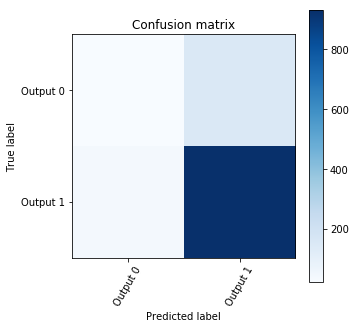

In [190]:
targets =['Output 0','Output 1']

score = metrics.accuracy_score(y_test,predictions[:,1]>0.5)
print ("Accuracy score:  {:.2%} \n".format(score))

print ("Classification report: ")
print(metrics.classification_report(y_test,predictions[:,1]>0.5, target_names=targets))

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,predictions[:,1]>0.5)
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix, targets)

##### Generate ROC curve

In [191]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

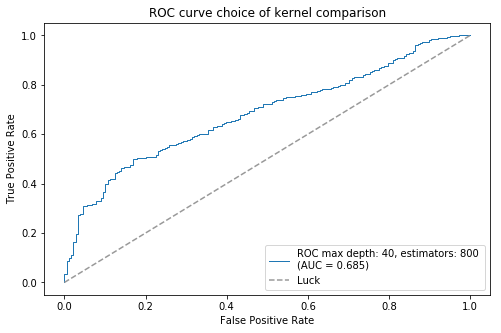

In [192]:
plt.figure(figsize=(8,5))
random_state = np.random.RandomState(37)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


probas_ = gbm.fit(X_train_1,y_train).predict_proba(X_test_1)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC max depth: %d, estimators: %d \n(AUC = %0.3f)' % (gbm.max_depth, gbm.n_estimators, roc_auc))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve choice of kernel comparison')
plt.legend(loc="lower right")
plt.show()

##### Try individual XGBoost

In [99]:
import xgboost as xgb
gbm_1 = xgb.XGBClassifier(seed=101, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862) #missing = -999


In [100]:
sensor_train_1.shape

(4584, 676)

In [101]:
sensor_test_1.shape

(1732, 676)

In [102]:
gbm_1.fit(sensor_train_1,Y, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=0.18357862, seed=101,
       silent=True, subsample=1)

In [104]:
predictions_1 = gbm_1.predict_proba(sensor_test_1)

##### Try individual RF

In [105]:
clf_1 = RandomForestClassifier(n_estimators=800, max_depth=40, random_state=101,class_weight={0:5,1:1})
clf_1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 5, 1: 1},
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=None, oob_score=False,
            random_state=101, verbose=0, warm_start=False)

##### Create confusion matrix for RF

In [106]:
targets =['Output 0','Output 1']

score = metrics.accuracy_score(y_test,clf_1.predict(X_test))
print ("Accuracy score:  {:.2%} \n".format(score))

print ("Classification report: ")
print(metrics.classification_report(y_test,clf_1.predict(X_test), target_names=targets))

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,clf_1.predict(X_test))
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix, targets)

ValueError: Found input variables with inconsistent numbers of samples: [1146, 1732]

In [193]:
#X_pred = sensor_test_1.values

#Y_pred= gbm_1.predict(X_pred)

df_Y_pred = pd.DataFrame(data=predictions_new, columns=['out1', 'out2'])

In [108]:
predictions_1[1:20]

array([[0.4904045 , 0.5095955 ],
       [0.5777011 , 0.4222989 ],
       [0.6102489 , 0.38975105],
       [0.6057012 , 0.39429882],
       [0.2561555 , 0.7438445 ],
       [0.02539766, 0.97460234],
       [0.6840428 , 0.3159572 ],
       [0.60857296, 0.391427  ],
       [0.30695695, 0.69304305],
       [0.02710515, 0.97289485],
       [0.4763841 , 0.5236159 ],
       [0.5500987 , 0.44990128],
       [0.14918739, 0.8508126 ],
       [0.4430374 , 0.5569626 ],
       [0.06553698, 0.934463  ],
       [0.6105517 , 0.38944826],
       [0.05023366, 0.94976634],
       [0.36256105, 0.63743895],
       [0.00775361, 0.9922464 ]], dtype=float32)

In [194]:
accuracy_score(Y, gbm_1.predict(sensor_train_1))

0.7303664921465969

In [196]:
#url2 = 'C:\\Users\\pinakibhagat\\Downloads\\Personal\\Harvard\\CSCIE-82\\Homework 4\\all\\ml08_submit_data_7thsub.csv'
url2 = 'C:\\Users\\corre\\Desktop\\CSCI E-82\\PS 4\\all\\ml08_submit_data_13thsub.csv'

df_Y_pred.to_csv(url2, sep=',')